Following from `m16_pdrt.py`.

In [1]:
import os

from pdrtpy.modelset import ModelSet
from pdrtpy.plot.modelplot import ModelPlot
from pdrtpy.measurement import Measurement
import pdrtpy.pdrutils as utils
from pdrtpy.tool.lineratiofit import LineRatioFit
from pdrtpy.plot.lineratioplot import LineRatioPlot

from astropy.nddata import StdDevUncertainty
import astropy.units as u
from astropy.table import Table

from copy import deepcopy

data_dir = "/home/ramsey/Documents/Research/Feedback/m16_data/catalogs/pdrt"
if not os.path.isdir(data_dir):
    data_dir = "/home/rkarim/Research/Feedback/m16_data/catalogs/pdrt"

def get_measurement_filename(line_stub):
    return os.path.join(data_dir, f"{line_stub}__pillar1_pointsofinterest_v3.txt")

user_models = {'CO_65/FIR': ('CO65_FIR.fits', "CO(J=6-5) / I$_{FIR}$")}

/home/ramsey/anaconda3/lib/python3.9/site-packages/pdrtpy/pbar.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


Utility functions

In [2]:
def load_user_model(ms, modelname):
    """
    September 28, 2022
    load a model I saved as FITS into a ModelSet
    """
    fn_stub, title = user_models[modelname]
    fn = os.path.join(data_dir, fn_stub)
    ms.add_model(modelname, fn, title=title)


def load_all_user_models(ms):
    """
    September 28, 2022
    load all models I created
    """
    for modelname in user_models:
        load_user_model(ms, modelname)


def collect_measurements_from_tables(line_or_ratio, reg_name=None):
    """
    Created: September 21, 2022
    Get any Measurement from the tables, make any valid ratio, and
    organize them by region.
    :param reg_name: If a reg_name is specified, only return those
    :returns: a Measurement; single pixel if reg_name specified
    """
    supported_line_stubs = ['cii', '12co10CONV', '13co10CONV', '12co32', '13co32', 'co65CONV', 'FIR']
    if '/' in line_or_ratio:
        line_or_ratio = [x.strip() for x in line_or_ratio.split('/')]
    elif isinstance(line_or_ratio, str):
        line_or_ratio = [line_or_ratio]

    if len(line_or_ratio) == 1:
        is_ratio = False
    elif len(line_or_ratio) == 2:
        is_ratio = True
    else:
        raise ValueError(f"Number of molecular lines can't be {len(line_or_ratio)} ({line_or_ratio})")

    fns = [get_measurement_filename(l) for l in line_or_ratio]
    meas_list = []
    if reg_name is not None:
        # Find the location of this region's row
        reg_i = None
        for fn in fns:
            if reg_i is None:
                t = Table.read(fn, format='ipac')
                reg_name_list = t['region']
                reg_i = list(reg_name_list).index(reg_name)
            meas_list.append(Measurement.from_table(fn, array=True)[reg_i])
    else:
        for fn in fns:
            # Get all regions in one Measurement
            meas_list.append(Measurement.from_table(fn, array=False))
    # Take ratio if we're doing that, otherwise just get the single value
    if is_ratio:
        meas = meas_list[0] / meas_list[1]
    else:
        meas = meas_list[0]
    return meas


def collect_all_measurements_for_region(reg_name):
    """
    Created: September 27, 2022
    Run collect_measurements_from_tables on every supported line intensity
    """
    supported_line_stubs = ['cii', 'co65CONV', 'FIR', '12co32', '12co10CONV', ] #  '13co32', '13co10CONV'
    result = []
    for line in supported_line_stubs:
        result.append(collect_measurements_from_tables(line, reg_name=reg_name))
    return result


def get_g0_values_at_locations(reg_name):
    """
    Created: September 21, 2022
    Get the G0 from Herschel (Nicola made this) and also the one from the
    stars that I made, return the two values as a tuple
    :param reg_name: the name of the region
    :return: dict(dict, dict)
        main dictionary keys 'Herschel_G0', 'Stars_G0'
        sub-dictionaries keys 'data', 'uncertainty', 'region'
        in a tuple ordered (Herschel, Stars)
    """
    fns = ["uv_m16_repro_CII", "g0_hillenbrand_stars_fuvgt4-5_ltxarcmin"]
    result = {}
    for raw_fn in fns:
        fn = get_measurement_filename(raw_fn)
        t = Table.read(fn, format='ipac')
        reg_name_list = t['region']
        reg_i = list(reg_name_list).index(reg_name)
        result[t['identifier'][reg_i]] = dict(t[reg_i])
    return result


In [4]:
meas_list = collect_all_measurements_for_region("W-peak")
ms = ModelSet("wk2020", z=1)
load_all_user_models(ms)

Adding user model CO_65/FIR


In [5]:
p = LineRatioFit(ms, measurements=meas_list)
p.run()
lrp_plot = LineRatioPlot(p)

/home/ramsey/anaconda3/lib/python3.9/site-packages/pdrtpy/tool/lineratiofit.py:384: UserWarning: LineRatioFit: No beam parameters in Measurement headers, assuming they are all equal!
  self._check_compatibility()


fitted 1 of 1 pixels
got 0 exceptions


None


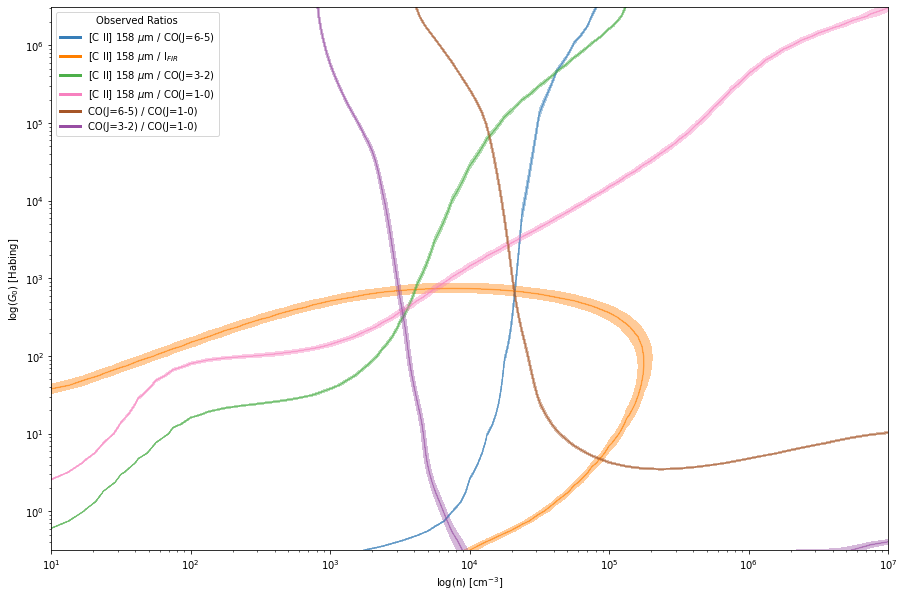

In [12]:
co65_meas = [x for x in meas_list if "65" in x.id].pop()
fir_meas = [x for x in meas_list if "FIR" in x.id].pop()
co65_fir_meas = co65_meas/fir_meas
print(co65_fir_meas.title)


# co65_fir_meas.title = user_models['CO_65/FIR'][1]
# print(co65_meas/fir_meas)
# new_meas_list = list(meas_list) + [co65_meas / fir_meas]
# print([x.id for x in new_meas_list])
# return
# new_meas_list = [x for x in new_meas_list if "FIR" not in x.id][-3:]
lrp_plot.overlay_all_ratios(yaxis_unit="Habing", figsize=(15, 10),
    loc='upper left')

In [ ]:
# g0_dict = get_g0_values_at_locations(reg_name)
# g0_plot_params = {'Stars_G0': ('#1f77b4', 'bottom'), 'Herschel_G0': ('#ff7f0e', 'top')}
# for g0_name in g0_dict:
#     color, va = g0_plot_params[g0_name]
#     lrp_plot._plt.axhline(g0_dict[g0_name]['data'], linestyle='--', color=color)
#     lrp_plot._plt.text(15, g0_dict[g0_name]['data'], g0_name.replace('_G0', ' $G_0$'), color=color, fontsize='large', va=va)


# dens, dens_unc = p.density.value, p.density.uncertainty.array
# radfield_meas = utils.to(utils.habing_unit, p.radiation_field)
# radfield, radfield_unc = radfield_meas.value, radfield_meas.uncertainty.array
# lrp_plot._plt.errorbar(dens, radfield, xerr=dens_unc, yerr=radfield_unc, color='k')